In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import glob, pdb, os, sys, cv2
from ripser import ripser
from persim import plot_diagrams
#import gudhi as gd
#from angio import angio_abm, radial_persistence, level_set_flooding, Persist_im
import matplotlib as mpl
from sklearn import svm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf') 

from custom_function import *

In [3]:
chi_vec = np.round(np.linspace(0,.5,11),2)
hapt_vec = np.round(np.linspace(0,.5,11),2)#np.array([0,.05,.1,.15])

topo = 'plane'#'plane_diag' #plane_diag , flood

num_data_sets = 10*len(chi_vec)*len(hapt_vec)

feature_len_persim = 2500

b0_persim_ones = []
b1_persim_ones = []
b0_persim_ramp = []
b1_persim_ramp = []

if topo == "plane":
    num_vecs = 4
elif topo == "flood":
    num_vecs = 1

for i in np.arange(num_vecs):
    b0_persim_ones.append(np.zeros((num_data_sets,feature_len_persim)))
    b1_persim_ones.append(np.zeros((num_data_sets,feature_len_persim)))
    b0_persim_ramp.append(np.zeros((num_data_sets,feature_len_persim)))
    b1_persim_ramp.append(np.zeros((num_data_sets,feature_len_persim)))


feature_len_Betti = 25

b0_betti = []
b1_betti = []

for i in np.arange(num_vecs):
    b0_betti.append(np.zeros((num_data_sets,feature_len_Betti)))
    b1_betti.append(np.zeros((num_data_sets,feature_len_Betti)))

labels = np.zeros((num_data_sets,))
chi_real_vec = np.zeros((num_data_sets,))
rho_real_vec = np.zeros((num_data_sets,))
real_vec = np.zeros((num_data_sets,))
    
count = 0
for i,chi in enumerate(chi_vec):
    for j,hapt in enumerate(hapt_vec):
        for real in np.arange(10):
            
            
            if "plane" in topo:
                for k,orient in enumerate(['left','right','top','bottom']):

                    #load in persistence images
                    mat = np.load("results/angio_"+topo+"_"+orient+"_persim_ramp_IC_linear_rho_"+str(hapt)+"_chi_"+str(chi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()
                    b0_persim_ramp[k][count,:] = mat['Ip'][0].reshape(-1)
                    b1_persim_ramp[k][count,:] = mat['Ip'][1].reshape(-1)

                    mat = np.load("results/angio_"+topo+"_"+orient+"_persim_ones_IC_linear_rho_"+str(hapt)+"_chi_"+str(chi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()
                    b0_persim_ones[k][count,:] = mat['Ip'][0].reshape(-1)
                    b1_persim_ones[k][count,:] = mat['Ip'][1].reshape(-1)


                    mat = np.load("results/angio_"+topo+"_"+orient+"_Betti_IC_linear_rho_"+str(hapt)+"_chi_"+str(chi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()

                    b0_betti[k][count,:] = mat['b0']
                    b1_betti[k][count,:] = mat['b1']

            elif topo == "flood":
                
                    #load in persistence images
                    mat = np.load("results/angio_"+topo+"_persim_ramp_IC_linear_rho_"+str(hapt)+"_chi_"+str(chi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()
                    b0_persim_ramp[0][count,:] = mat['Ip'][0].reshape(-1)
                    b1_persim_ramp[0][count,:] = mat['Ip'][1].reshape(-1)

                    mat = np.load("results/angio_"+topo+"_persim_ones_IC_linear_rho_"+str(hapt)+"_chi_"+str(chi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()
                    b0_persim_ones[0][count,:] = mat['Ip'][0].reshape(-1)
                    b1_persim_ones[0][count,:] = mat['Ip'][1].reshape(-1)


                    mat = np.load("results/angio_"+topo+"_Betti_IC_linear_rho_"+str(hapt)+"_chi_"+str(chi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()

                    b0_betti[0][count,:] = mat['b0']
                    b1_betti[0][count,:] = mat['b1']


                    
            
            chi_real_vec[count] = chi
            rho_real_vec[count] = hapt
            labels[count] = len(hapt_vec)*i + j
            
            real_vec[count] = real

                
            count+=1

## Elbow curve for number of clusters

In [ ]:
'''###
### All doubles of feature vectors
###

X_vec_ind = b0_persim_ones + b1_persim_ones  + b0_persim_ramp + b1_persim_ramp + b0_betti + b1_betti
feats = ['PIO','PIR','BC']
if "plane" in topo:
    orients = ["LTR","RTL","TTB","BTT"]
elif topo == "flood":
    orients = [""]

title_vec_ind = []
for feat in feats:
    for i in np.arange(2):
        for orient in orients:
            title_vec_ind.append(r"$\beta_"+str(i)+"$ "+orient+" "+feat)         

X_vec = []
title_vec = []
for i in np.arange(len(X_vec_ind)):
    for j in np.arange(i+1,len(X_vec_ind)):
        X_vec.append(np.hstack((X_vec_ind[i],X_vec_ind[j])))
        title_vec.append(title_vec_ind[i] + " and " + title_vec_ind[j])'''

### Top double features
X_vec = [np.hstack((b0_persim_ones[0],b0_persim_ones[1])),
         np.hstack((b0_persim_ones[1],b1_persim_ramp[0])),
         np.hstack((b0_persim_ramp[2],b1_persim_ramp[0])),
         np.hstack((b0_persim_ramp[3],b1_persim_ramp[0]))]
title_vec = ["b0_PIO_LTR_and_b0_PIO_RTL",
             "b0_PIO_RTL_and_b1_PIR_LTR",
             "b0_PIR_TTB_and_b1_PIR_LTR",
             "b0_PIR_BTT_and_b1_PIR_LTR"]


        
score_vec = np.zeros((9,len(X_vec)))  
for i,X in enumerate(X_vec):


    for num_clusters in np.arange(1,10):
        #### perform clustering
        kmeans_classes,acc,acc_in_sample,_ = clustering_fine_train_test(X,chi_real_vec,rho_real_vec,
                                                real_vec,num_clusters=num_clusters)


        
        score_vec[num_clusters-1,i] = acc

fig = plt.figure(figsize=(8,6))      
ax = fig.add_subplot(111)
for i in np.arange(len(X_vec)):
    ax.plot(np.arange(1,10),score_vec[:,i]*100,label = title_vec[i])
plt.legend(fontsize=10)
ax.set_xlabel("Number of clusters ($k$)")
ax.set_ylabel("OOS Accuracy %")
ax.set_title("Elbow Curve")
ax.set_xticks(np.arange(1,10))
plt.savefig('figures/elbow_top.pdf', format='pdf')

In [ ]:
fig = plt.figure(figsize=(8,6))      
ax = fig.add_subplot(111)
for i in np.arange(len(X_vec)):
    ax.plot(np.arange(1,10),score_vec[:,i]*100,label = title_vec[i])
ax.set_xlabel("Number of clusters ($k$)")
ax.set_ylabel("OOS Accuracy \%")
ax.set_title("Elbow Curve")
#plt.legend(fontsize=10)

score_mean = np.mean(score_vec*100,axis=1)
score_std = np.std(score_vec*100,axis=1)

'''ax = fig.add_subplot(111)
ax.plot(np.arange(1,10),score_mean,'b.-',label = title_vec[i])
ax.plot(np.arange(1,10),score_mean + 2*score_std,'b--',label = title_vec[i])
ax.plot(np.arange(1,10),score_mean - 2*score_std,'b--',label = title_vec[i])
ax.set_xlabel("Number of clusters ($k$)")
ax.set_ylabel("OOS Accuracy %")
ax.set_title("Elbow Curve")
ax.set_xticks(np.arange(1,10))
plt.savefig('figures/elbow_all.pdf', format='pdf')'''


In [ ]:
'''### Best individual features
X_vec = [b1_persim_ramp[0],b0_persim_ones[0],b1_persim_ones[1],b1_persim_ones[0]]
title_vec = ["b1_PIR_LTR","b0_PIO_LTR","b1_PIO_RTL","b1_PIO_LTR"]
'''

### Top double features
X_vec = [np.hstack((b0_persim_ones[0],b0_persim_ones[1])),
         np.hstack((b0_persim_ones[1],b1_persim_ramp[0])),
         np.hstack((b0_persim_ramp[2],b1_persim_ramp[0])),
         np.hstack((b0_persim_ramp[3],b1_persim_ramp[0])),
         np.hstack((b0_persim_ramp[0],b1_persim_ramp[0])),]
title_vec = ["b0_PIO_LTR_and_b0_PIO_RTL",
             "b0_PIO_RTL_and_b1_PIR_LTR",
             "b0_PIR_TTB_and_b1_PIR_LTR",
             "b0_PIR_BTT_and_b1_PIR_LTR",
             "b0_PIR_LTR_and_b1_PIR_LTR",]


score_vec = np.zeros((9,len(X_vec)))  
for i,X in enumerate(X_vec):


    for num_clusters in np.arange(1,10):
        #### perform clustering
        filename = "Classes_"+title_vec[i]
        
        kmeans_classes,acc,acc_in_sample,_ = clustering_fine_train_test(X,chi_real_vec,rho_real_vec,
                                                real_vec,num_clusters=num_clusters)


        
        score_vec[num_clusters-1,i] = acc

plt.figure()      
for i in np.arange(len(X_vec)):
    plt.plot(np.arange(1,10),score_vec[:,i]*100,label = title_vec[i])
plt.xlabel("Number of clusters ($k$)")
plt.ylabel("OOS Accuracy \%")
plt.title("Elbow Curve")
plt.legend(fontsize=10)



## Running classification scheme

<IPython.core.display.Javascript object>


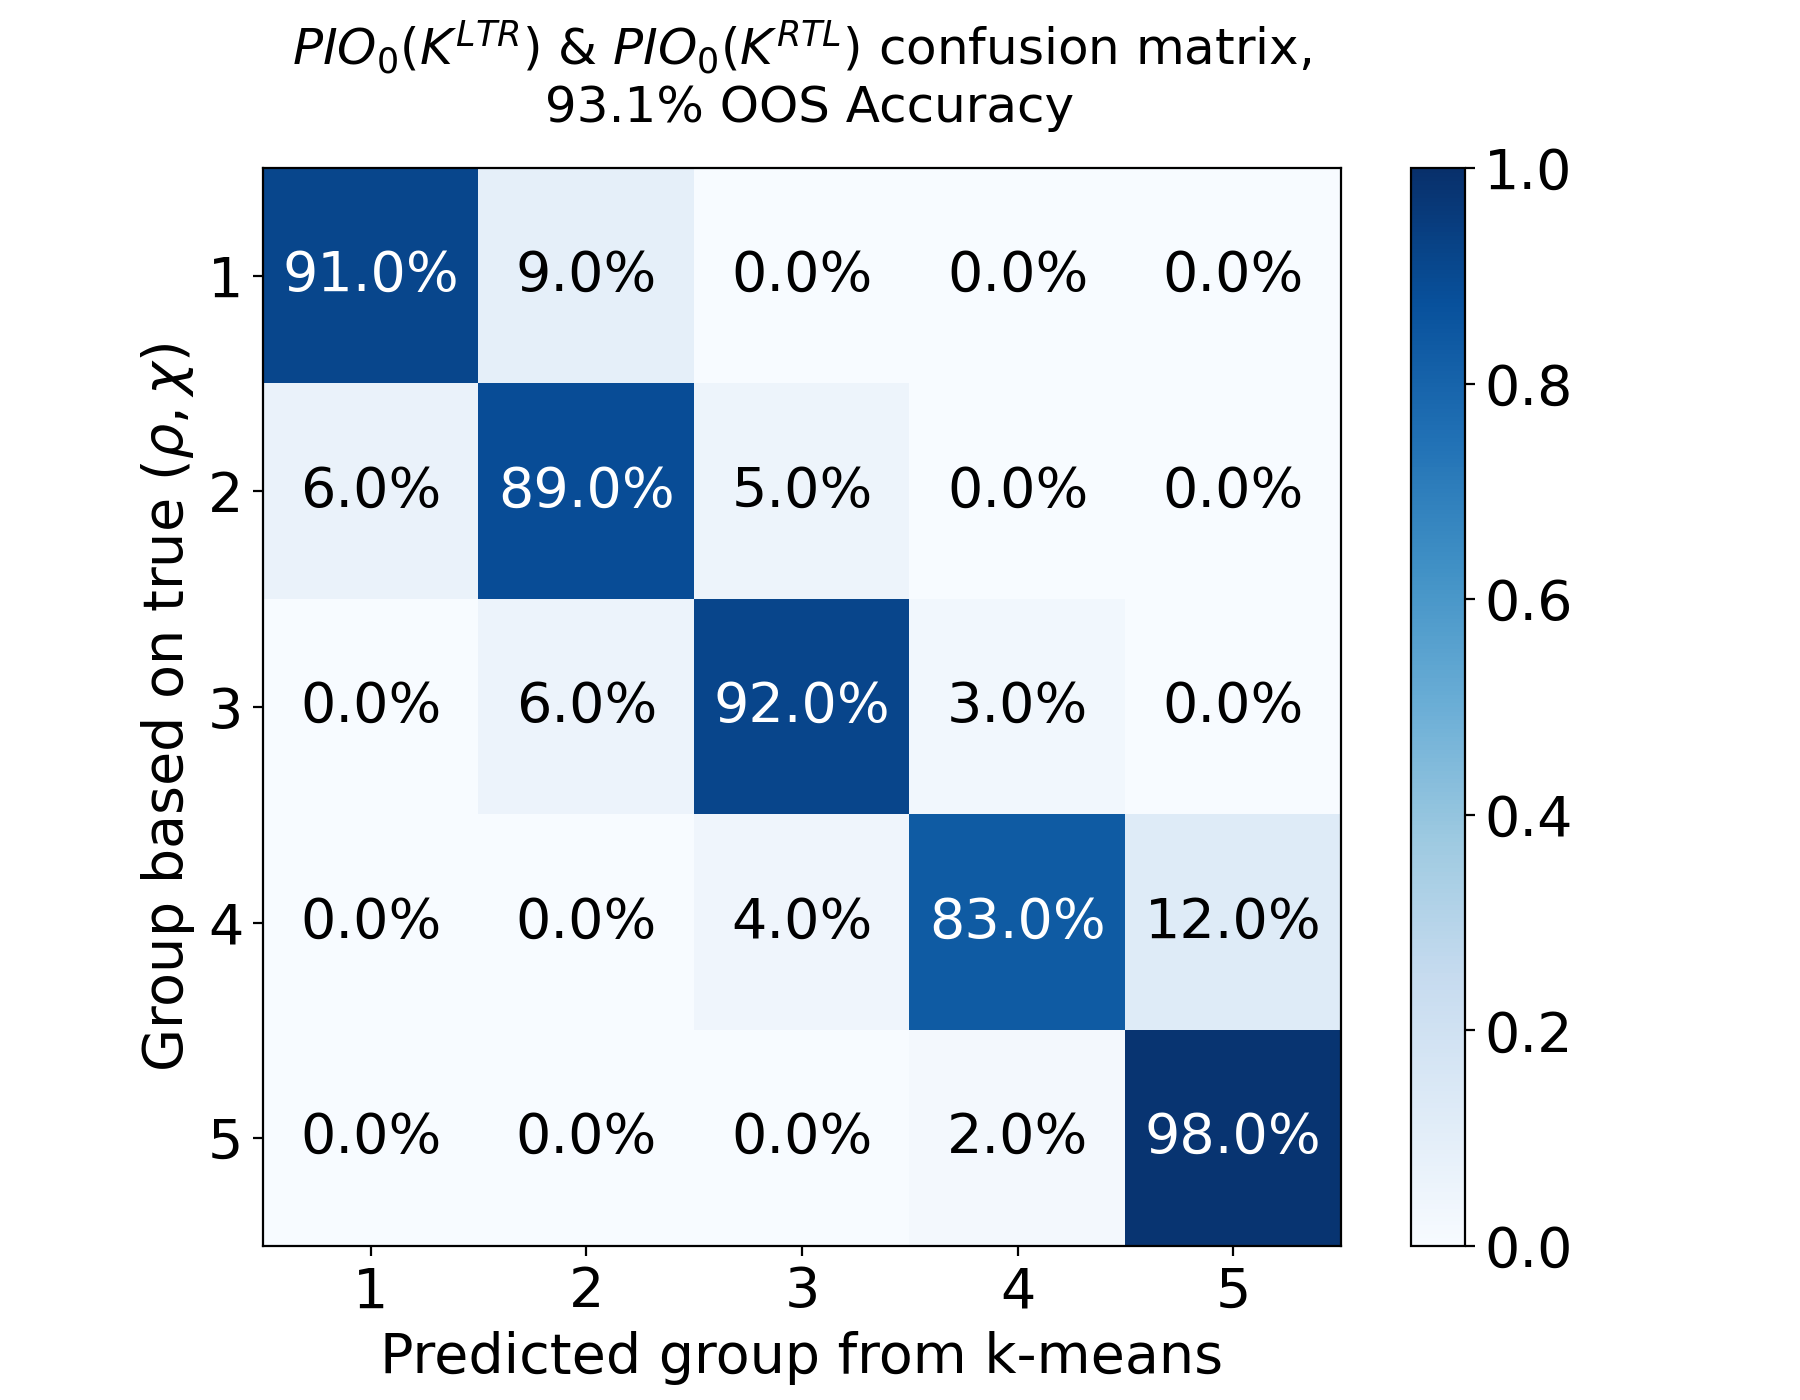

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<IPython.core.display.Javascript object>


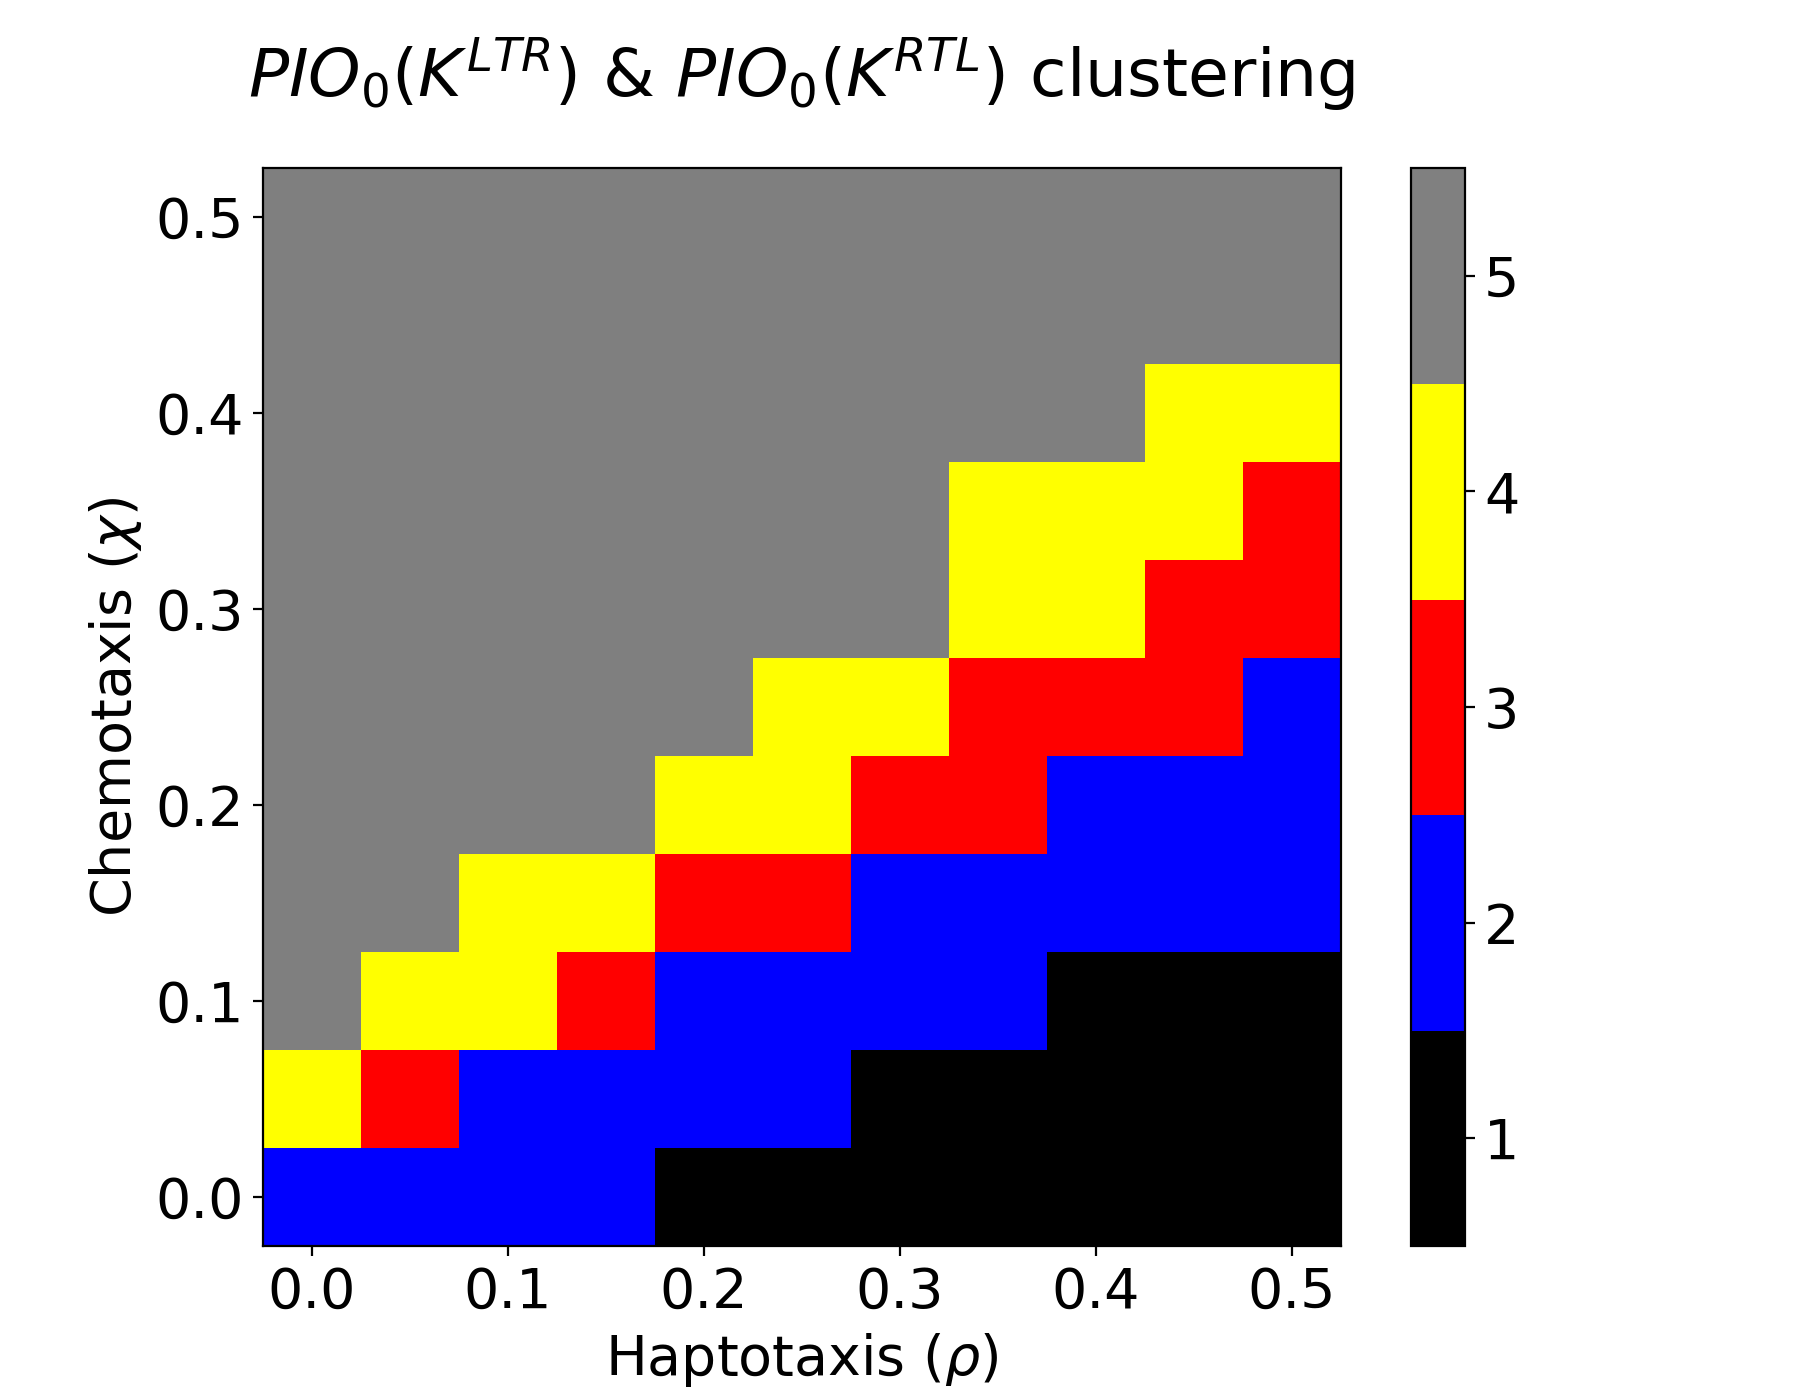

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


b0_PIO_LTR_and_b0_PIO_RTL, acc = 0.931129476584022


In [4]:
'''
### All features
X_vec = [b0_persim_ramp,b1_persim_ramp,b0_persim_ones,b1_persim_ones,b0_betti,b1_betti]
title_vec = ["b0_persim_ramp","b1_persim_ramp","b0_persim_ones","b1_persim_ones","b0_betti","b1_betti"]

X_vec = b0_persim_ones + b1_persim_ones  + b0_persim_ramp + b1_persim_ramp + b0_betti + b1_betti
feats = ['persim_ones','persim_ramp','betti']
orients = ['left','right','top','bottom']
title_vec = []
for feat in feats:
    for i in np.arange(2):
        for orient in orients:
            title_vec.append("b"+str(i)+"_"+orient+"_"+feat)

'''


'''### Best individual features
X_vec = [b1_persim_ramp[0],b0_persim_ones[0],b1_persim_ones[1],b1_persim_ones[0]]
title_vec = ["b1_PIR_LTR","b0_PIO_LTR","b1_PIO_RTL","b1_PIO_LTR"]
title_vec_fig = [r"$PIR_1(K^{LTR})$",r"$PIO_0(K^{LTR})$",r"$PIO_1(K^{RTL})$",r"$PIO_1(K^{LTR})$"]
'''

### Top double features
X_vec = [np.hstack((b0_persim_ones[0],b0_persim_ones[1]))]#,
'''np.hstack((b0_persim_ones[1],b1_persim_ramp[0])),
np.hstack((b0_persim_ramp[2],b1_persim_ramp[0])),
np.hstack((b0_persim_ramp[3],b1_persim_ramp[0]))]
'''
title_vec = ["b0_PIO_LTR_and_b0_PIO_RTL",
             "b0_PIO_RTL_and_b1_PIR_LTR",
             "b0_PIR_TTB_and_b1_PIR_LTR",
             "b0_PIR_BTT_and_b1_PIR_LTR"]

title_vec_fig = [r"$PIO_0(K^{LTR})$ & $PIO_0(K^{RTL})$",
                 r"$PIO_0(K^{RTL})$ & $PIR_1(K^{LTR})$",
                 r"$PIR_0(K^{TTB})$ & $PIR_1(K^{LTR})$",
                 r"$PIR_0(K^{BTT})$ & $PIR_1(K^{LTR})$"]


'''### Top LTR/RTL/BTT/TTB features
X_vec = [np.hstack((b0_persim_ones[0],b0_persim_ones[1])),
         np.hstack((b0_persim_ramp[0],b0_persim_ramp[1])),
         np.hstack((b1_persim_ones[0],b1_persim_ones[3])),
         np.hstack((b1_betti[0],b1_betti[1]))]
title_vec = ["b0_PIO_LTR_and_RTL",
             "b0_PIR_LTR_and_RTL",
             "b1_PIO_LTR_and_BTT",
             "b1_BC_LTR_and_RTL",]
title_vec_fig = [r"$\beta_0$ PIO LTR and RTL",
                 r"$\beta_0$ PIR LTR and RTL",
                 r"$\beta_1$ PIO LTR and BTT",
                 r"$\beta_1$ BC LTR and RTL",]'''



#### perform clustering
#filename = "Classes_"+title_vec[i]
for i,X in enumerate(X_vec):
    kmeans_classes,acc,acc_in_sample,centers = clustering_fine_train_test(X,chi_real_vec,rho_real_vec,
                                                real_vec,num_clusters=5,
                                                filename = "param_clustering_"+title_vec[i]+"_"+topo,
                                                title=title_vec_fig[i])

    print(title_vec[i] + ", acc = " + str(acc))



In [ ]:
kmeans_train_ranked[np.logical_and(chi_train==0,rho_train==0)]

In [ ]:
chi_train = chi_real_vec[real_vec<7]
rho_train = rho_real_vec[real_vec<7]
real_train = real_vec[real_vec<7]
kmeans_train = kmeans_classes[real_vec<7]

chi_train_mean = []
for i in np.arange(5):
    chi_train_mean.append(np.mean(chi_train[kmeans_train==i]))

kmeans_train_ranked = np.zeros(kmeans_train.shape)

for i, cluster in enumerate(np.argsort(chi_train_mean)):
    kmeans_train_ranked[kmeans_train==cluster] = i+1
    #print(i,cluster)

rho_vec = np.unique(rho_real_vec)
chi_vec = np.unique(chi_real_vec)
chi_rho_means = np.zeros((len(rho_vec),len(chi_vec)))

for i,rho in enumerate(rho_vec):
    for j,chi in enumerate(chi_vec):
        chi_rho_means[i,j] = np.mean(kmeans_train_ranked[np.logical_and(chi_train==chi,rho_train==rho)])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.matshow(np.flipud(chi_rho_means.T),fignum=0)
ax.xaxis.tick_bottom()
ax.set_xticks([0,2,4,6,8,10])       
ax.set_yticks([0,2,4,6,8,10])               

ax.set_xticklabels(chi_vec[::2])
ax.set_yticklabels(chi_vec[::-2])
        
plt.colorbar()
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\chi$")
plt.title("Averaged cluster assignment")
plt.savefig("Average_clusters.pdf",format="pdf")

## Creating Accuracy Table

In [ ]:
'''####
####### All individual features
#######
X_vec = b0_persim_ones + b1_persim_ones  + b0_persim_ramp + b1_persim_ramp + b0_betti + b1_betti
feats = ['persim\_ones','persim\_ramp','betti']

feats_title = ['PIO','PIR',r'$\beta$']
if "plane" in topo:
    orients = ["LTR","RTL","TTB","BTT"]
elif topo == "flood":
    orients = ["flood"]

title_vec = []
for feat in feats_title:
    for i in np.arange(2):
        for orient in orients:
            title_vec.append(feat + r"$_"+str(i)+"(K^{"+orient+"})$")   '''      




###
### All doubles of feature vectors
###
X_vec_ind = b0_persim_ones + b1_persim_ones  + b0_persim_ramp + b1_persim_ramp + b0_betti + b1_betti
feats = ['PIO','PIR','BC']
if "plane" in topo:
    orients = ["LTR","RTL","TTB","BTT"]
elif topo == "flood":
    orients = ["flood"]

title_vec_ind = []
for feat in feats:
    for i in np.arange(2):
        for orient in orients:
            title_vec_ind.append(feat + r"$_"+str(i)+"(K^{"+orient+"})$")         

X_vec = []
title_vec = []
for i in np.arange(len(X_vec_ind)):
    for j in np.arange(i+1,len(X_vec_ind)):
        X_vec.append(np.hstack((X_vec_ind[i],X_vec_ind[j])))
        title_vec.append(title_vec_ind[i] + " \& " + title_vec_ind[j])


print(title_vec)
print(len(title_vec))


create_latex_table_classification_sort(X_vec,title_vec,chi_real_vec,
                                  rho_real_vec,real_vec,num_clusters=5)


In [ ]:
class_num = np.max(kmeans_classes) + 1

#
#for kclass in np.arange(class_num):
fig = plt.figure(figsize=(12,3))
count = 1

for i in np.arange(1):
    for kclass in np.arange(class_num):
#    for i in np.arange(6):
    
        #find all realizations of this class
        class_reals = np.where(kmeans_classes==kclass)[0]
        #randomly pick one
        random_sample = np.random.permutation(class_reals)[0]

        #find real, hapt, chi
        real = random_sample%10
        hapt = (random_sample%(len(hapt_vec)*10))//10
        chi = random_sample//(len(hapt_vec)*10)

        #load in bio data
        mat = np.load("results/angio_bio_data_IC_linear_rho_"+str(hapt_vec[hapt])+"_chi_"+str(chi_vec[chi])+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()

        #plot network
        ax = fig.add_subplot(1,class_num,count)
        ax.matshow(mat['N'].T)
        ax.set_xticks([])
        ax.set_yticks([])
        if i ==0:
            ax.set_title("Class " + str(kclass))
        count += 1
#plt.savefig("figures/cluster_examples_"+title_vec[0]+"_"+topo+".pdf",format="pdf")

In [ ]:


### Top double feature
X = np.hstack((b0_persim_ones[0],b0_persim_ones[1]))
title_vec = "b0_PIO_LTR_and_b0_PIO_RTL"

title_vec_fig = [r"$\beta_0$ PIO LTR and $\beta_0$ PIO RTL"]


kmeans_classes,acc,acc_in_sample,centers = clustering_fine_train_test(X,chi_real_vec,rho_real_vec,
                                                real_vec,num_clusters=5)#,
                                                #filename = "param_clustering_"+title_vec[i]+"_"+topo,title=title_vec_fig[i])




In [ ]:
#find simulation closest to mean value
chi_means = []
rho_means = []
real_means = []

for i in np.arange(5):
    center_loc = np.argmin([np.linalg.norm(centers[i,:] - row) for row in X])
    
    #underlying params
    chi_means.append(chi_real_vec[center_loc])
    rho_means.append(rho_real_vec[center_loc])
    real_means.append(np.int(real_vec[center_loc]))

print(rho_means)    
print(chi_means)


## Previous clustering figure

In [ ]:
x = np.linspace(0,1,201)
y = x.copy()

x2 = np.linspace(0,1,50)
y2 = x2.copy()

font = {'size'   : 8}
plt.rc('font', **font)

cmaplist = [(1.0,1.0,1.0),(1,1,1),(1,0,0)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N = 3)

count = 0

fig = plt.figure(figsize=(10,15))

#this order was manually picked to arrange groups in order
for i in [4,1,3,2,0]:
    
    #find simulation closest to mean value
    center_loc = np.argmin([np.linalg.norm(centers[i,:] - row) for row in X])
    
    chi = chi_means[i]
    rho = rho_means[i]
    real = np.int(real_means[i])
    mat = np.load("results/angio_bio_data_IC_linear_rho_"+str(rho)+"_chi_"+str(chi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()

    #plt.matshow(mat['N'][:,:].T)
    N = mat['N']
    
    ax = fig.add_subplot(5,3,count*3 + 1)
    cm = ax.contourf(x,y,N.T,vmin=0,vmax=1,cmap=cmap)
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    ax.set_ylabel("Group " + str(count+1),fontsize=20)
    if count == 0:
        ax.set_title("Representative \n Network",fontsize=20)
    
    '''ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['left'].set_linewidth(0.15)
    ax.spines['top'].set_linewidth(0.15)
    ax.spines['bottom'].set_linewidth(0.15)    
    ax.spines['right'].set_linewidth(0.15)    
    ax.set_xlabel("Space ($x$)")'''
    
    mat = np.load("results/angio_"+topo+"_left_persim_ramp_IC_linear_rho_"+str(rho)+"_chi_"+str(chi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()
    mat_RTL = np.load("results/angio_"+topo+"_right_persim_ramp_IC_linear_rho_"+str(rho)+"_chi_"+str(chi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()
    
    #max_val = np.max(np.hstack((mat['Ip'][0],mat_RTL['Ip'][0])))
    #min_val = np.min(np.hstack((mat['Ip'][0],mat_RTL['Ip'][0])))
    
    ax = fig.add_subplot(5,3,count*3 + 2)
    
    max_val = np.max(mat['Ip'][0])
    min_val = np.min(mat['Ip'][0])
    
    ax.contourf(x2,y2,mat['Ip'][0].T,aspect='auto',levels = np.linspace(min_val*1.1,max_val,10))#,vmax = .005)
    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_title(TDA + " $B_0$ LTR persistence image")
    if count == 0:
        ax.set_title(r"$\beta_0$ PIO LTR",fontsize=20)
    
    
    
    ax = fig.add_subplot(5,3,count*3 + 3)

    max_val = np.max(mat_RTL['Ip'][0])
    min_val = np.min(mat_RTL['Ip'][0])
 
    
    #ax.matshow(np.flipud(mat['Ip'][0].T),aspect='auto')#,vmax = .005)
    cont1 = ax.contourf(x2,y2,mat_RTL['Ip'][0].T,aspect='auto',levels = np.linspace(min_val*1.1,max_val,10))#,vmax = .005)
    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_title(TDA + " $B_0$ RTL persistence image")

    if count == 0:
        ax.set_title(r"$\beta_0$ PIO RTL",fontsize=20)
    
    plt.colorbar(cont1)
    
    count += 1
plt.subplots_adjust(left=0.1,bottom=0.04,top=0.9,right = 0.97)
fig.suptitle(r"Mean Cluster Realizations from $\beta_0$ LTR PIO and $\beta_0$ RTL PIO",fontsize=23)
#plt.savefig("grouping_b0_PIO_LTR_b0_PIO_RTL.pdf",format="pdf")

## Current figure (networks only)

In [ ]:
x = np.linspace(0,1,201)
y = x.copy()

x2 = np.linspace(0,1,50)
y2 = x2.copy()

font = {'size'   : 8}
plt.rc('font', **font)

cmaplist = [(1.0,1.0,1.0),(1,1,1),(1,0,0)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N = 3)

count = 0

fig = plt.figure(figsize=(10*1.5,6*1.5))

#this order was manually picked to arrange groups in order
for i in [4,1,3,2,0]:
    
    #find simulation closest to mean value
    center_loc = np.argmin([np.linalg.norm(centers[i,:] - row) for row in X])
    
    chi = chi_means[i]
    rho = rho_means[i]
    real = np.int(real_means[i])
    mat = np.load("results/angio_bio_data_IC_linear_rho_"+str(rho)+"_chi_"+str(chi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()

    print(rho,chi)
    
    #plt.matshow(mat['N'][:,:].T)
    N = mat['N']
    
    ax = fig.add_subplot(2,3,count + 1,adjustable="box")
    cm = ax.contourf(x,y,N.T,vmin=0,vmax=1,cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title("Group " + str(count+1),fontsize=20)
    #if count == 0:
    #    ax.set_title("Representative \n Network",fontsize=20)
    
    mat = np.load("results/angio_"+topo+"_left_persim_ramp_IC_linear_rho_"+str(rho)+"_chi_"+str(chi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()
    mat_RTL = np.load("results/angio_"+topo+"_right_persim_ramp_IC_linear_rho_"+str(rho)+"_chi_"+str(chi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()
    
    
    count += 1
plt.subplots_adjust(left=0.1,bottom=0.04,top=0.9,right = 0.97)
fig.suptitle(r"Mean Cluster Realizations from PIO$_0(K^{LTR})$ & PIO$_0(K^{RTL})$",fontsize=23)
plt.savefig("grouping_b0_PIO_LTR_b0_PIO_RTL.pdf",format="pdf")